In [5]:
import sys
import os
import keras_rcnn
from keras_rcnn import backend, datasets, layers, models, preprocessing
import numpy
import cv2
import matplotlib
import keras
import json
import rcnn_utils
import skimage
from sklearn.model_selection import train_test_split
%matplotlib inline

Definitions

In [6]:
train_json_file = '../input/DSB208_train.json'
# test_json_file = '/home/paperspace/bowl/DSB208_test.json'
train_path = '../input/stage1_train/'
test_path = '../input/stage1_test/'
nuclei_clust_path = '../input/nuclei_clusters.json'

target_size = (None,None)
batch_size = 1

train = True

classes = {
	"n1": 1,
	"n2": 2,
	"n3": 3
}
num_classes = len(classes) + 1

weights_path = '../models/rcnn_%sclasses.hdf5' % num_classes

build model

In [7]:
print('building model...')
model_input = keras.layers.Input((None, None, 3))

model = keras_rcnn.models.RCNN(model_input, classes=num_classes)

model.load_weights(weights_path)

optimizer = keras.optimizers.Adam(0.0001)
# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

model.compile(optimizer)
# model.summary(line_length=150)
# model.fit_generator(generator, epochs=10, steps_per_epoch=len(training))
# model.save_weights(weights_path)

building model...


/home/paperspace/anaconda3/lib/python3.6/site-packages/keras_rcnn/models/_rcnn.py:91: UserWarning: Output "object_detection_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "object_detection_2" during training.
  super(RCNN, self).compile(optimizer, None)


loading data...


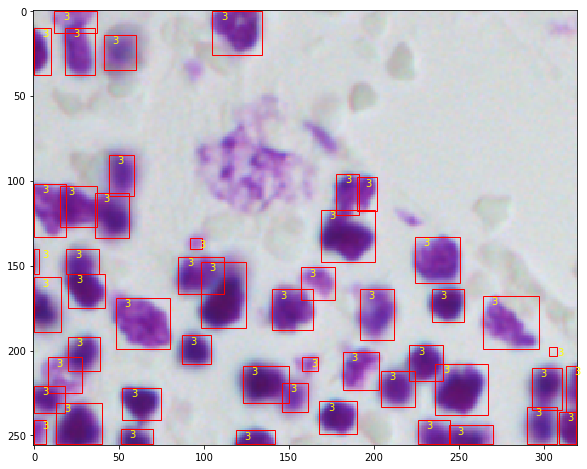

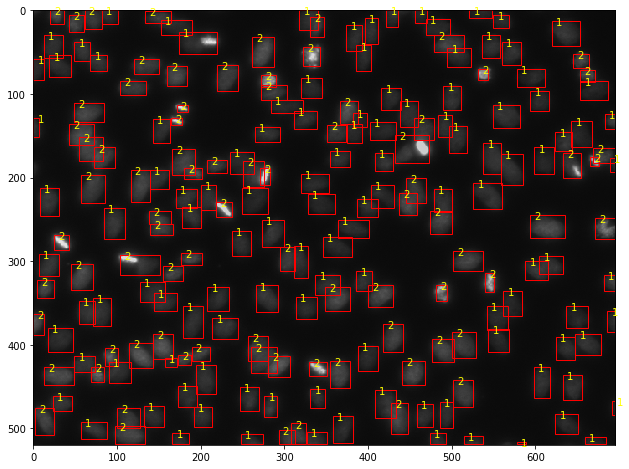

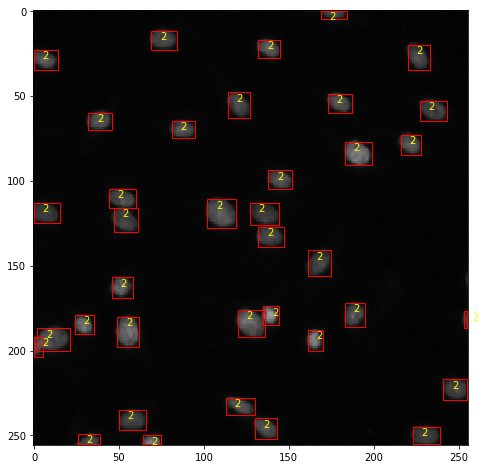

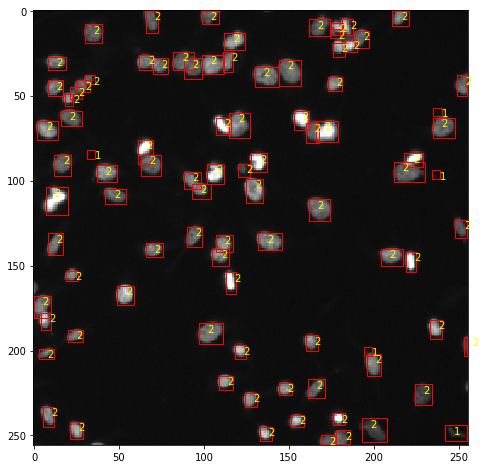

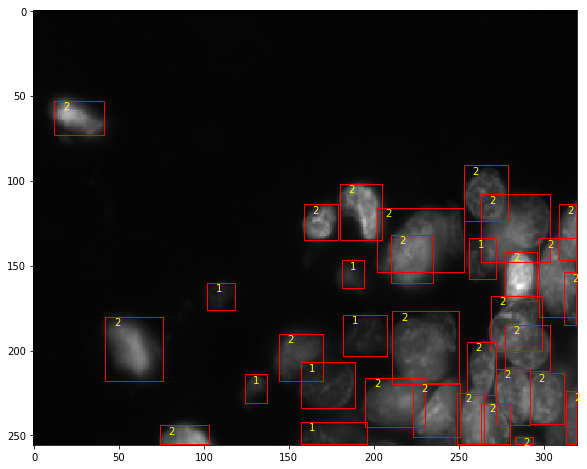

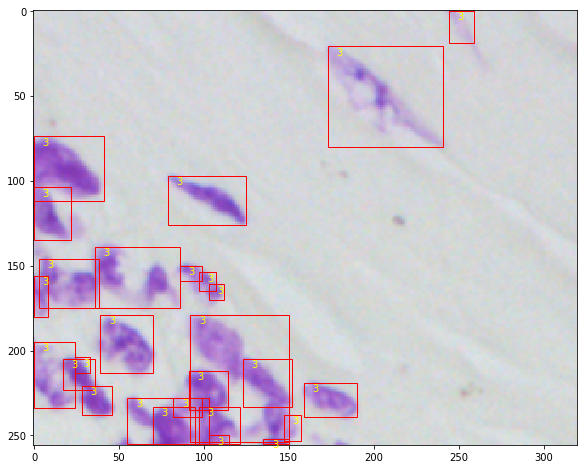

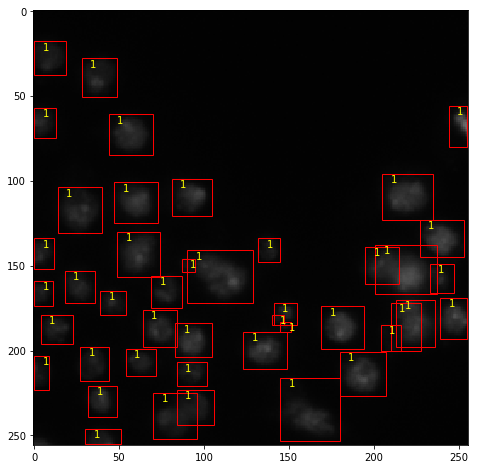

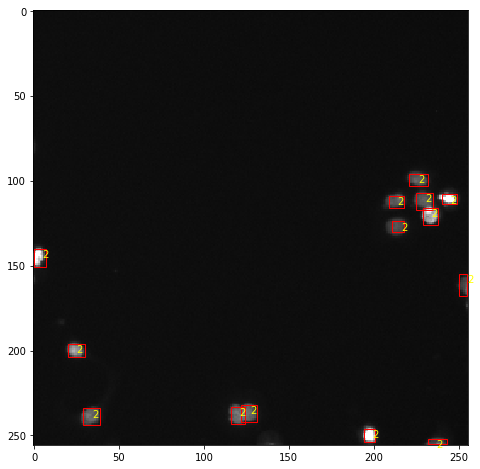

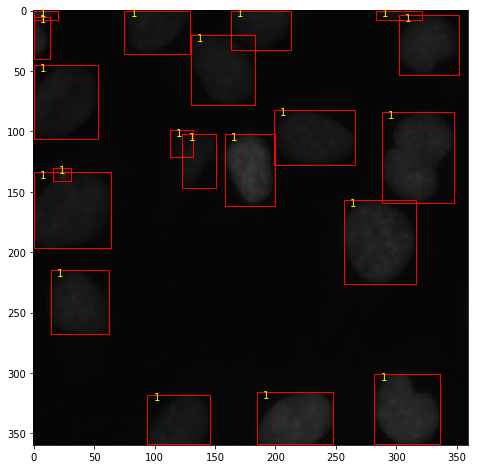

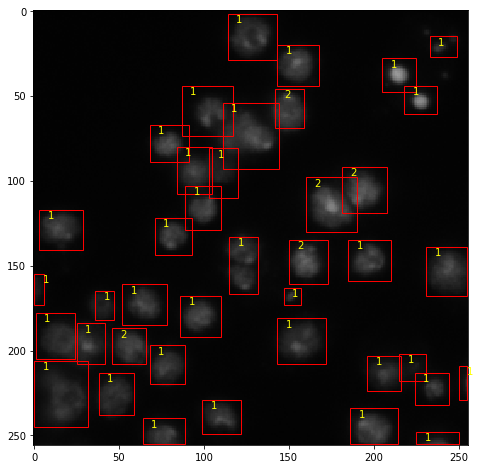

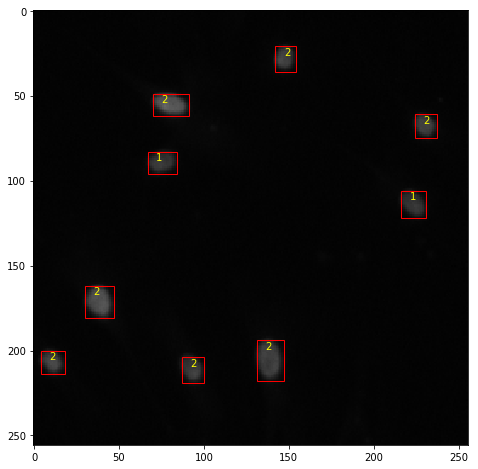

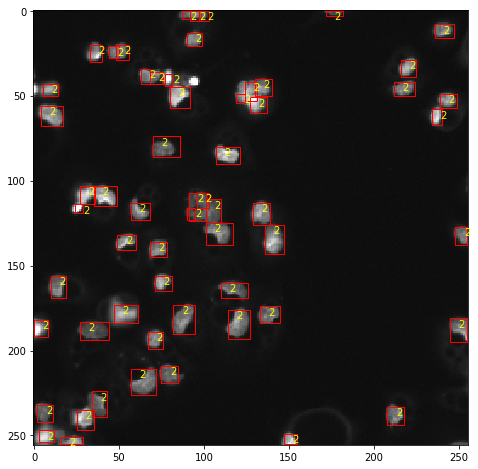

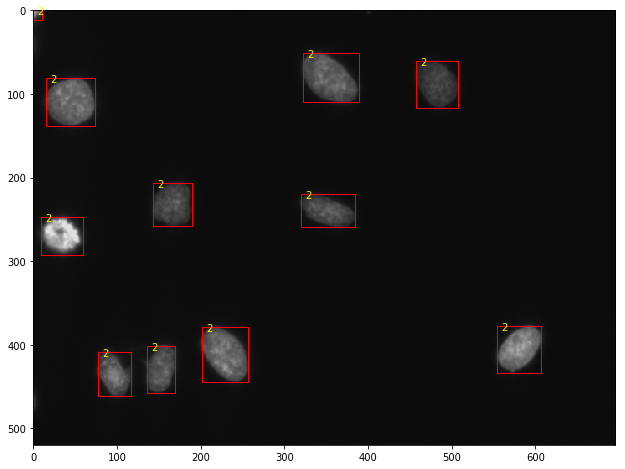

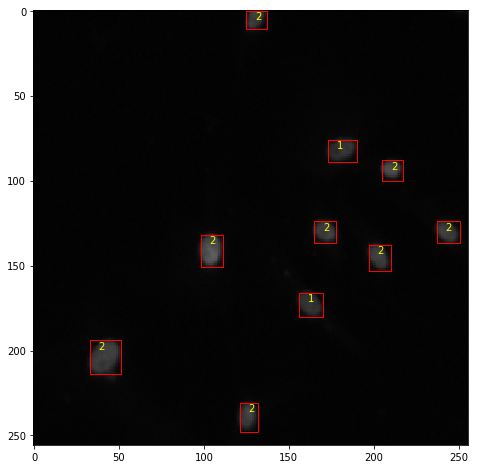

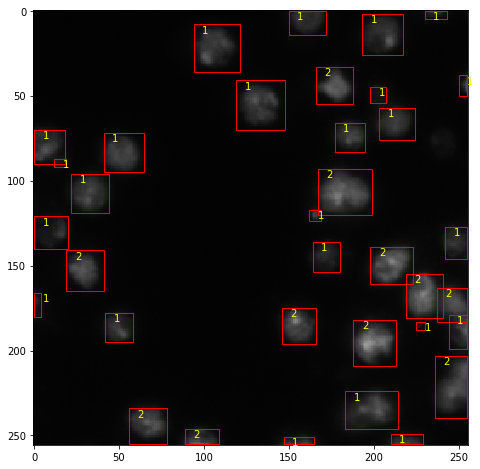

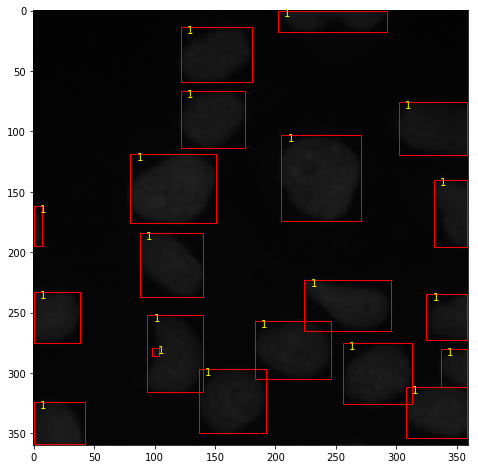

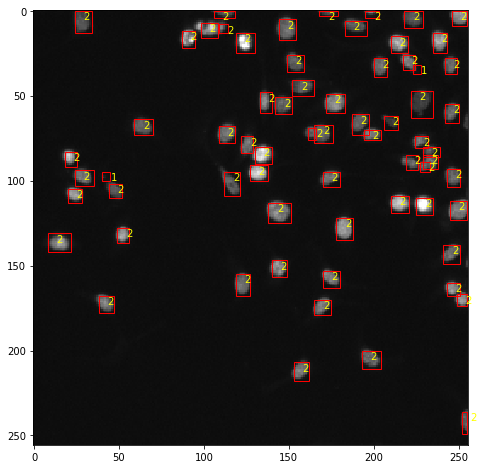

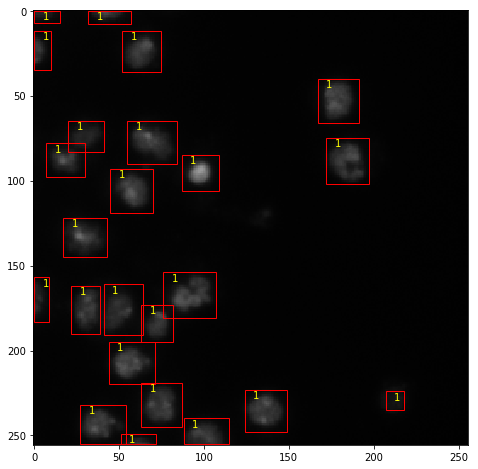

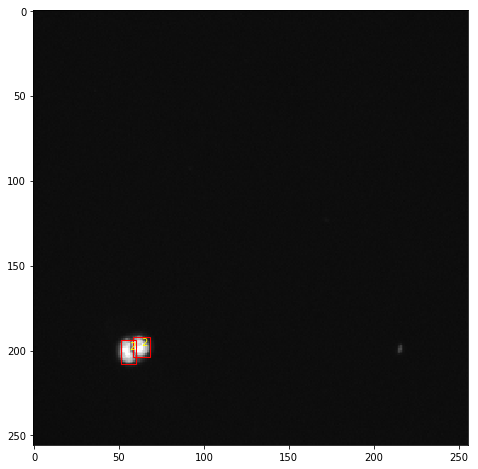

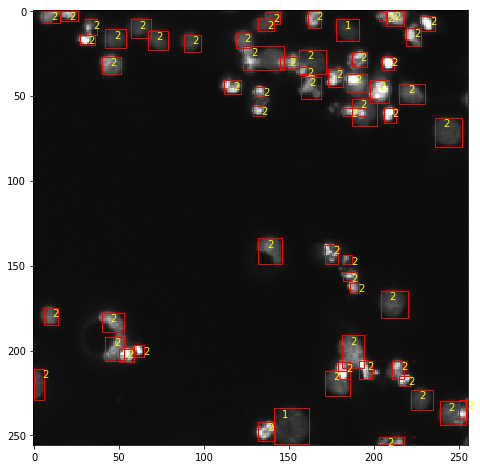

/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
603/603 [==============================] - 980s 2s/step - loss: 3.1825 - val_loss: 7.2174
Epoch 2/5
603/603 [==============================] - 1052s 2s/step - loss: 2.7902 - val_loss: 6.4565
Epoch 3/5
603/603 [==============================] - 1095s 2s/step - loss: 2.5194 - val_loss: 6.3743
Epoch 4/5
 92/603 [===>..........................] - ETA: 15:01 - loss: 2.2210

ResourceExhaustedError: OOM when allocating tensor with shape[100352,256]
	 [[Node: training_1/Adam/gradients/time_distributed_7/while/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@time_distributed_7/while/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Adam/gradients/time_distributed_7/while/MatMul_grad/MatMul_1/StackPopV2, training_1/Adam/gradients/time_distributed_7/while/Relu_grad/ReluGrad)]]

Caused by op 'training_1/Adam/gradients/time_distributed_7/while/MatMul_grad/MatMul_1', defined at:
  File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e711a90f16a2>", line 122, in <module>
    model.fit_generator(generator, epochs=5, steps_per_epoch=len(training)/batch_size, validation_data=val_gen, validation_steps=len(val), callbacks=[checkpoint])
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 2026, in fit_generator
    self._make_train_function()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 970, in _make_train_function
    loss=self.total_loss)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 434, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 602, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 374, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 602, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 938, in _MatMulGrad
    grad_b = math_ops.matmul(a, grad, transpose_a=True)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1898, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2497, in _mat_mul
    name=name)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3033, in create_op
    op_def=op_def)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1521, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'time_distributed_7/while/MatMul', defined at:
  File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-090709b14395>", line 4, in <module>
    model = keras_rcnn.models.RCNN(model_input, classes=num_classes)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras_rcnn/models/_rcnn.py", line 76, in __init__
    output_regions = keras.layers.TimeDistributed(keras.layers.Dense(256, activation="relu"))(output_regions)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 188, in call
    unroll=False)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2764, in rnn
    swap_memory=True)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2819, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2643, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2593, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2750, in _step
    tuple(constants))
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 179, in step
    output = self.layer.call(x, **kwargs)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 855, in call
    output = K.dot(inputs, self.kernel)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1072, in dot
    out = tf.matmul(x, y)
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1898, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100352,256]
	 [[Node: training_1/Adam/gradients/time_distributed_7/while/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@time_distributed_7/while/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Adam/gradients/time_distributed_7/while/MatMul_grad/MatMul_1/StackPopV2, training_1/Adam/gradients/time_distributed_7/while/Relu_grad/ReluGrad)]]


In [8]:
if train:
	with open(train_json_file, 'r') as file:
		training = json.load(file)
	with open(nuclei_clust_path, 'r') as file:
		nuclei_clusters = json.load(file)
	training, val = train_test_split(training, test_size=0.1, random_state=7)
	#with open(train_json_file, 'w') as file:
	#	json.dump(training, file)
	#sys.exit()
	#for item in training:
	#	for object_ in item['objects']:
	#		if '/DSB2018' in object_['mask']['pathname']:
	#			object_['mask']['pathname'] = '../input' + object_['mask']['pathname'][object_['mask']['pathname'].find('/DSB2018'):]
	#with open(train_json_file, 'w') as file:
	#	json.dump(training, file)
	#sys.exit()
    
	for item in training:
		#item['shape'] = (item['image']['shape']['r'], item['image']['shape']['c'], item['image']['shape']['channels'])
		#item['filename'] = item['image']['pathname']
		#item['boxes'] = []
		#for x in item['objects']:
			#item['boxes'].append({})
			#item['boxes'][-1]['class'] = x['class']
			#item['boxes'].append([x['bounding_box']['minimum']['c'], x['bounding_box']['minimum']['r'], 
			#            x['bounding_box']['maximum']['c'], x['bounding_box']['maximum']['r']])
			#item['boxes'][-1]['x1'] = x['bounding_box']['minimum']['c']
			#item['boxes'][-1]['x2'] = x['bounding_box']['maximum']['c']
			#item['boxes'][-1]['y1'] = x['bounding_box']['minimum']['r']
			#item['boxes'][-1]['y2'] = x['bounding_box']['maximum']['r']
		# item['boxes'] = []
		# for x in item['objects']:

			# item['boxes'].append([x['bounding_box']['minimum']['c'], x['bounding_box']['minimum']['r'], 
			#            x['bounding_box']['maximum']['c'], x['bounding_box']['maximum']['r']])
		item['boxes'] = numpy.array(item['boxes'])
		item['class'] = numpy.array([[0,1] for x in range(len(item['boxes']))])

	print('loading data...')
	generator = iter(rcnn_utils.train_gen(training, nuclei_clusters, num_classes, batch_size, target_size))
	val_gen = iter(rcnn_utils.train_gen(val, nuclei_clusters, num_classes, batch_size, (None, None)))
	# with open(train_json_file, 'w') as file:
	#   json.dump(training, file)
	# sys.exit()
	
	# training, validation = sklearn.model_selection.train_test_split(training)
	
	

	for _ in range(0,20):
		(target_bounding_boxes, target_image, target_scores, meta), _ = next(generator)
		target_bounding_boxes = numpy.reshape(target_bounding_boxes, (-1, 4))

		target_image = numpy.squeeze(target_image)

		target_scores = numpy.argmax(target_scores, -1)

		target_scores = numpy.reshape(target_scores, (-1))

		#print(target_bounding_boxes.shape)
		#print(target_image.shape)
		#print(target_scores.shape)

		_, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

		axis.imshow(target_image)
		#if len(list(target_scores)) > 0:
		for target_index, target_score in enumerate(target_scores):
			if target_score > 0:
				xy = [target_bounding_boxes[target_index][0],target_bounding_boxes[target_index][1]]
				#print(xy)
				w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
				h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]
				rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")
				#print(xy, w, h)
				axis.add_patch(rectangle)
				axis.text(xy[0], xy[1]+5, target_score, color='yellow')
		matplotlib.pyplot.show()

	# sys.exit()




	# for i in range(0, 5):
	#   target_image = skimage.io.imread(training[i]['filename'])[:,:,:3]
	#   target_bounding_boxes = training[i]['boxes']
	#   target_scores = training[i]['class']
	#   #print('loading one image')
	#   #(target_bounding_boxes, target_image, target_scores, _), _ = generator.next()
	#   #print('loaded one image')
	#   #target_bounding_boxes = numpy.squeeze(target_bounding_boxes)

	#   #target_image = numpy.squeeze(target_image)

	#   # target_scores = numpy.argmax(target_scores, -1)

	#   # target_scores = numpy.squeeze(target_scores)

	#   _, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

	#   axis.imshow(target_image)

	#   #for target_index, target_score in enumerate(target_scores):
	#   for i, box in enumerate(target_bounding_boxes):
	#       #if target_score > 0:
	#       target_score = target_scores[i]
	#       xy = [
	#           box['x1'],
	#           box['y1']
	#       ]

	#       w = box['x2'] - box['x1']
	#       h = box['y2'] - box['y1']

	#       rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")

	#       axis.add_patch(rectangle)

	#   matplotlib.pyplot.show()
	checkpoint = keras.callbacks.ModelCheckpoint(weights_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
	model.fit_generator(generator, epochs=5, steps_per_epoch=len(training)/batch_size, validation_data=val_gen, validation_steps=len(val), callbacks=[checkpoint])
	model.save_weights(weights_path)


else:
	test_generator = rcnn_utils.test_gen(test_path, num_classes)
	test_ids = next(os.walk(test_path))[1]
	# visualize prediction
	preds = []
	for i in range(0, 2):
		example = next(test_generator)
		target_bounding_boxes, target_image, target_labels, _ = example
		#target_bounding_boxes = numpy.squeeze(target_bounding_boxes)
		target_image = numpy.squeeze(target_image)
		#target_labels = numpy.argmax(target_labels, -1)
		#target_labels = numpy.squeeze(target_labels)
		# output_anchors, output_proposals, output_deltas, output_scores = model.predict(example)
		output_anchors, output_scores = model.predict(example)
		preds.append((output_anchors, output_scores))
		output_anchors = numpy.squeeze(output_anchors)
		# output_proposals = numpy.squeeze(output_proposals)
		# output_deltas = numpy.squeeze(output_deltas)
		output_scores = numpy.squeeze(output_scores)
		_, axis = matplotlib.pyplot.subplots(1)
		axis.imshow(target_image)
		axis.set_title(test_ids[i])
		#for index, label in enumerate(target_labels):
		#   if label == 1:
		#       xy = [
		#       target_bounding_boxes[index][0],
		#       target_bounding_boxes[index][1]
		#       ]
		#       w = target_bounding_boxes[index][2] - target_bounding_boxes[index][0]
		#       h = target_bounding_boxes[index][3] - target_bounding_boxes[index][1]
		#       rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="g", facecolor="none")
		#       axis.add_patch(rectangle)
		for index, score in enumerate(output_scores):
			print(score)
			if max(score[1:]) > 0.0:
				xy = [
				output_anchors[index][0],
				output_anchors[index][1]
				]
				w = output_anchors[index][2] - output_anchors[index][0]
				h = output_anchors[index][3] - output_anchors[index][1]
				rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")
				axis.add_patch(rectangle)